In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn
import time 
import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
import psutil


In [3]:
import cupy as cp

In [4]:
from hydra.utils import to_absolute_path

In [5]:
import numpy as np

In [6]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        self.overlap = cfg.overlap 
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap=self.sequence_length
        )
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=2000,
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)
            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))
            

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [7]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [18]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

def global_mean_and_std_edge_length_vectorized(X, triangles):
    """
    Calcule la longueur moyenne globale et l'écart-type des edges parmi tous les triangles de manière vectorisée.

    Parameters:
        X (numpy.ndarray): Un tableau de forme (n, 2) ou (n, 3), contenant les coordonnées des sommets.
        triangles (numpy.ndarray): Un tableau de forme (m, 3), contenant les indices des sommets de chaque triangle.

    Returns:
        tuple: La longueur moyenne globale des edges et l'écart-type des longueurs.
    """
    # Récupérer les coordonnées des sommets pour chaque triangle
    p1 = X[triangles[:, 0]]
    p2 = X[triangles[:, 1]]
    p3 = X[triangles[:, 2]]
    print(np.linalg.norm(p1 - p2, axis=1))
    # Calculer les longueurs des edges
    edge_lengths = np.array([
        np.linalg.norm(p1 - p2, axis=1),  # Longueur entre p1 et p2
        np.linalg.norm(p2 - p3, axis=1),  # Longueur entre p2 et p3
        np.linalg.norm(p3 - p1, axis=1)   # Longueur entre p3 et p1
    ])
    edge_lengths = edge_lengths.ravel()
    # Calculer la moyenne globale et l'écart-type
    mean_length = np.mean(edge_lengths)
    std_length = np.std(edge_lengths)

    return mean_length, std_length


print(global_mean_and_std_edge_length_vectorized(X, triangles))

[98.65777063 90.66481132 98.65777063 ... 88.7008982   6.26573241
  2.92541256]
(27.881502595730353, 28.54687251546918)


In [35]:
mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70/Mesh_base.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_base.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Mesh4_base.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_base.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_base.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex32/Mesh32_base.bin']
for mesh in mesh_list :
    print(mesh)
    edge_lengths = dgl.load_graphs(mesh)[0][0].edata['x'][:,-1].numpy()
    print(np.min(edge_lengths))
    print(np.mean(edge_lengths))
    print(np.max(edge_lengths))

/work/m24046/m24046mrcr/results_data_30min_35_70/Mesh_base.bin
0.75025076
15.743155
82.96846
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_base.bin
1.5195184
27.938509
159.05518
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Mesh4_base.bin
3.0137174
48.407185
319.86438
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_base.bin
5.8978944
81.024826
630.1554
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_base.bin
12.005401
141.1687
1148.2379
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex32/Mesh32_base.bin
66.46377
282.5359
2301.4993


In [41]:
multi_mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/Multimesh_2_32_True.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Multimesh_2_32.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Multimesh_4_32.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Multimesh_8_32.bin','/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Multimesh_16_32.bin']
for mesh in multi_mesh_list :
    print(mesh)
    edge_lengths = dgl.load_graphs(mesh)[0][0].edata['x'][:,-1].numpy()
    print(np.min(edge_lengths[edge_lengths!=0.0]))
    print(np.mean(edge_lengths))
    print(np.max(edge_lengths))

/work/m24046/m24046mrcr/results_data_30min/Multimesh_2_32_True.bin
0.75025076
24.788212
2293.7317
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Multimesh_2_32.bin
1.5195184
43.346478
2288.1208
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex4/Multimesh_4_32.bin
3.0137174
71.474525
2363.0027
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Multimesh_8_32.bin
5.8978944
110.43697
2521.218
/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Multimesh_16_32.bin
12.005401
171.56242
2410.4043


In [10]:
def global_smallest_edge_length_vectorized(X, triangles):
    """
    Trouve la longueur minimale globale des edges parmi tous les triangles de manière vectorisée.

    Parameters:
        X (numpy.ndarray): Un tableau de forme (n, 2) ou (n, 3), contenant les coordonnées des sommets.
        triangles (numpy.ndarray): Un tableau de forme (m, 3), contenant les indices des sommets de chaque triangle.

    Returns:
        float: La longueur minimale globale des edges.
    """
    # Récupérer les coordonnées des sommets pour chaque triangle
    p1 = X[triangles[:, 0]]
    p2 = X[triangles[:, 1]]
    p3 = X[triangles[:, 2]]
    # Calculer les longueurs des edges
    edge_lengths = np.array([
        np.linalg.norm(p1 - p2, axis=1),  # Longueur entre p1 et p2
        np.linalg.norm(p2 - p3, axis=1),  # Longueur entre p2 et p3
        np.linalg.norm(p3 - p1, axis=1)   # Longueur entre p3 et p1
    ])
    print(edge_lengths.shape)
    # Trouver le minimum global
    min_length = np.min(edge_lengths)
    
    return min_length

min_length = global_smallest_edge_length_vectorized(X,triangles)

(3, 819322)


In [11]:
print(min_length)

0.7502507456308959


In [12]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70/maillage_3.slf']
res_mesh_fine = TelemacFile(mesh_list[0])
X_fine,triangles_fine = add_mesh_info(res_mesh_fine)

In [13]:
import pickle
from scipy.interpolate import griddata

fine_values = []
list_of_test_files = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl'
]
#list_of_test_files = ['/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl']

#list_of_test_files = ['/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
#                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
#                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl']


In [14]:
sequence_length = 13
overlap = 13
sequences = []
for file_path in list_of_test_files:
    with open(file_path, 'rb') as f:
        dynamic_data = pickle.load(f)
        step = max(1, sequence_length - overlap)
        for i in range(0, len(dynamic_data) - sequence_length + 1, step):
            sequence = dynamic_data[i:i + sequence_length]
            sequences.append(sequence)

In [21]:
fine_gd = []
fine_ori = []
for seq in sequences : 
    a,b = seq[-1]
    correct = a+b
    fine_gd.append(correct)
    fine_ori.append(seq[0][0])

In [24]:
print(len(fine_gd))
print(len(predict))

57
57


### Projection

In [14]:
import numpy as np
from matplotlib.tri import Triangulation
from scipy.spatial import Delaunay

fine_data = fine_gd

# Définir les bornes de votre domaine
xmin = min(X[:, 0].min(), X_fine[:, 0].min())
xmax = max(X[:, 0].max(), X_fine[:, 0].max())
ymin = min(X[:, 1].min(), X_fine[:, 1].min())
ymax = max(X[:, 1].max(), X_fine[:, 1].max())

print("la")
# Calculer le nombre de points dans chaque dimension en fonction de min_length
Nx = int(np.ceil((xmax - xmin) / min_length)) + 1
Ny = int(np.ceil((ymax - ymin) / min_length)) + 1
print(Nx,Ny)
# Créer une grille régulière avec min_length comme écart
grid_x, grid_y = np.mgrid[xmin:xmax:Nx*1j, ymin:ymax:Ny*1j]
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T  # Shape: (n_grid_points, 2)

# Create a mask for the domain using the fine mesh triangulation
triangulation_mask = Triangulation(X_fine[:, 0], X_fine[:, 1], triangles=triangles_fine)
mask = triangulation_mask.get_trifinder()(grid_x, grid_y) != -1  # True inside the domain
mask_flat = mask.ravel()

print("la2")
# Precompute triangulations
tri_coarse = Delaunay(X)
print("la3")
# Compute simplex indices 

def find_simplex_chunk(tri_coarse, points_chunk):
    """Helper function to process a subset of points."""
    return tri_coarse.find_simplex(points_chunk)

# Suppose these are already defined:
# tri_coarse = Delaunay(X)
# grid_points = large array (N, 2)
N = len(grid_points)

load = True

if load : 
    simplex_indices = np.load("./datas/simplex_indices.npy")
else : 
    chunk_size = 500000  # or some value that fits well in memory
    num_chunks = (N + chunk_size - 1) // chunk_size
    print("Nombre de chunks : {}".format(num_chunks))
    # Option 1: Serial chunking
    simplex_indices = np.empty(N, dtype=np.int32)
    offset = 0
    for i in range(num_chunks):
        if i%10 == 0 :
            print(f"Chunk {i} / {num_chunks}", flush=True)
        start = i * chunk_size
        end = min((i+1)*chunk_size, N)
        chunk_result = tri_coarse.find_simplex(grid_points[start:end])
        simplex_indices[start:end] = chunk_result
    np.save("./datas/simplex_indices.npy", np.array(simplex_indices))

la
24875 22898
la2
la3


In [15]:
free_bytes, total_bytes = cp.cuda.runtime.memGetInfo()
print(f"Mémoire libre : {free_bytes / (1024**2):.2f} MB")
print(f"Mémoire totale : {total_bytes / (1024**2):.2f} MB")

Mémoire libre : 80694.56 MB
Mémoire totale : 81111.50 MB


In [16]:
import psutil

# Get total and available memory
total_memory = psutil.virtual_memory().total / (1024 ** 3)  # Convert to GB
available_memory = psutil.virtual_memory().available / (1024 ** 3)  # Convert to GB
print(total_memory)
print(available_memory)

510.37261962890625
456.0467529296875


In [17]:
# Apply the mask to simplex indices
simplex_indices_coarse_masked = np.where(mask_flat, simplex_indices, -1)
# Identify valid points inside the domain and within a simplex
valid_coarse = simplex_indices_coarse_masked >= 0

In [18]:
transform_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], :2]
offset_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], 2]

In [19]:
print("grid_points shape:", grid_points.shape)
print("valid_coarse shape:", valid_coarse.shape)
print("offset_coarse shape:", offset_coarse.shape)
print("transform_coarse shape:", transform_coarse.shape)

grid_points shape: (569587750, 2)
valid_coarse shape: (569587750,)
offset_coarse shape: (306470938, 2)
transform_coarse shape: (306470938, 2, 2)


In [20]:
print("Number of True values in valid_coarse:", np.sum(valid_coarse))


Number of True values in valid_coarse: 306470938


In [21]:
selected_points = grid_points[valid_coarse]

In [22]:
print(selected_points.shape)
print(offset_coarse.shape)
import psutil

# Get total and available memory
total_memory = psutil.virtual_memory().total / (1024 ** 3)  # Convert to GB
available_memory = psutil.virtual_memory().available / (1024 ** 3)  # Convert to GB
print(total_memory)
print(available_memory)

(306470938, 2)
(306470938, 2)
510.37261962890625
435.489013671875


In [23]:
delta_coarse = selected_points - offset_coarse

In [ ]:
bary_coords_coarse = np.vstack(result)
bary_coords_coarse = np.hstack((bary_coords_coarse, 1 - bary_coords_coarse.sum(axis=1, keepdims=True)))
print("la5")

In [1]:
# Interpolation function remains unchanged
def interpolate_values(tri_simplices, simplex_indices, bary_coords, values, valid_indices, n_grid_points):
    n_variables = values.shape[1]
    result = np.full((n_grid_points, n_variables), 0.0)
    for idx, i in enumerate(valid_indices):
        simplex_index = simplex_indices[idx]
        indices = tri_simplices[simplex_index]
        bc = bary_coords[idx]
        v = values[indices]
        interpolated_value = np.dot(bc, v)
        result[i] = interpolated_value
    return result

def interpolate_values_cupy(
    tri_simplices,
    simplex_indices,
    bary_coords,
    values,
    valid_indices,
    n_grid_points
):
    """
    Version vectorisée sur GPU de votre fonction d'interpolation.
    """
    # 1) On copie les gros tableaux en CuPy
    tri_simplices_gpu    = cp.asarray(tri_simplices)      # (n_simplices, 3)
    simplex_indices_gpu  = cp.asarray(simplex_indices)    # (n_grid_points,)
    bary_coords_gpu      = cp.asarray(bary_coords)        # (n_valid, 3)
    values_gpu           = cp.asarray(values)             # (n_nodes, n_vars)
    valid_indices_gpu    = cp.asarray(valid_indices)      # (n_valid,)

    n_vars = values.shape[1]

    # Crée le tableau résultat (sur GPU) : (n_grid_points, n_vars)
    result_gpu = cp.zeros((n_grid_points, n_vars), dtype=cp.float32)

    # Indices de simplex effectifs (pour les points valides)
    chosen_simplex = simplex_indices_gpu[valid_indices_gpu]  # (n_valid,)

    # On récupère les 3 nœuds de chaque simplex
    # tri_simplices_gpu[chosen_simplex].shape = (n_valid, 3)
    tri_pts = tri_simplices_gpu[chosen_simplex]  # indices de sommets

    # On « déplie » pour récupérer les valeurs associées aux sommets
    # tri_pts.reshape(-1) a shape (n_valid*3,)
    # values_gpu[ ... ] aura shape (n_valid*3, n_vars)
    pred_flat = values_gpu[tri_pts.reshape(-1)]  
    # On redimensionne pour retrouver l'axe des 3 sommets
    # => (n_valid, 3, n_vars)
    pred_flat = pred_flat.reshape(-1, 3, n_vars)

    # Barycentres : (n_valid, 3) -> (n_valid, 3, 1)
    bary_coords_expanded = bary_coords_gpu[:, :, None]  # Ajout d'un axe singleton

    # Produit barycentrique vectorisé :
    #   (n_valid, 3, n_vars) * (n_valid, 3, 1)
    # puis somme sur l’axe=1 (les 3 sommets)
    interpolated_val = (pred_flat * bary_coords_expanded).sum(axis=1)  # (n_valid, n_vars)

    # On range le résultat aux bonnes positions
    result_gpu[valid_indices_gpu] = interpolated_val

    # On rapatrie sur CPU
    result_cpu = cp.asnumpy(result_gpu)

    return result_cpu

# Number of grid points
n_grid_points = grid_points.shape[0]

#import time 

# Interpolate coarse predictions
#projected_predi = []
#for pred in predict:
    #t1 = time.time()
    #interpolated_values = interpolate_values(
    #    tri_coarse.simplices,
    #    simplex_indices_coarse_masked[valid_coarse],
    #    bary_coords_coarse,
    #    pred,
    #    np.where(valid_coarse)[0],
    #    n_grid_points
    #)
    #t2 = time.time()
    #print(t2-t1)
#    interpolated_values = interpolate_values_cupy(
#        tri_coarse.simplices,                  # CPU array
#        simplex_indices_coarse_masked,         # CPU array
#        bary_coords_coarse,                    # CPU array
#        pred,                                  # CPU array
#        np.where(valid_coarse)[0],            # CPU array
#        n_grid_points
#    )
    #print(time.time()-t2)
    
    #print(np.sum(interpolated_values-interpolated_values_gpus))
    #print(np.mean(interpolated_values-interpolated_values_gpus))
        
    # Reshape to grid shape and number of variables
#    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
#    projected_predi.append(interpolated_values)
    
#cp._default_memory_pool.free_all_blocks()
#cp.cuda.Stream.null.synchronize()


NameError: name 'np' is not defined

In [ ]:
import numpy as np
import cupy as cp

def hann_2d(Nx, Ny, dtype=np.float32):
    """Fenêtre de Hann 2D en float32."""
    w_x = np.hanning(Nx).astype(dtype)
    w_y = np.hanning(Ny).astype(dtype)
    return np.outer(w_x, w_y)

def radial_average_spectrum_cupy(spectrum_gpu, center=None):
    ny, nx = spectrum_gpu.shape
    if center is None:
        center = (nx//2, ny//2)
    x0, y0 = center

    y_gpu, x_gpu = cp.indices((ny, nx))
    r_gpu = cp.sqrt((x_gpu - x0)**2 + (y_gpu - y0)**2)
    r_int_gpu = r_gpu.astype(cp.int32)

    r_int_flat_gpu = r_int_gpu.ravel()
    spectrum_flat_gpu = spectrum_gpu.ravel()
    
    r_max = int(r_int_gpu.max().get())

    sumvals_gpu = cp.bincount(r_int_flat_gpu, weights=spectrum_flat_gpu)
    counts_gpu  = cp.bincount(r_int_flat_gpu)
    sumvals_gpu  = sumvals_gpu.astype(cp.float32)
    counts_gpu   = counts_gpu.astype(cp.float32)
    rad_ave_gpu = sumvals_gpu / cp.where(counts_gpu == 0, cp.float32(1), counts_gpu)

    r_vals_gpu = cp.arange(r_max+1, dtype=cp.float32)

    r_vals_cpu = cp.asnumpy(r_vals_gpu)
    rad_ave_cpu = cp.asnumpy(rad_ave_gpu)
    return r_vals_cpu, rad_ave_cpu

def process_fft_and_radial(data_cpu, window_2d_cpu):
    """
    data_cpu  : un tableau NumPy (Ny, Nx, nb_channels) en float32 (de préférence).
    window_2d_cpu : fenêtre Hann (Ny, Nx) en float32.

    On:
    1) traite canal par canal
    2) fait la fft2 sur GPU
    3) calcule la moyenne radiale
    4) stocke le profil rad (sur CPU) dans un tableau de résultat
    Retourne: 
      - r_vals (un seul vecteur rayon, identique pour tous les canaux si la taille ne change pas)
      - rad_profiles : shape (nb_channels, len(r_vals))
    """
    Ny, Nx, nchan = data_cpu.shape
    # On copie la fenêtre sur GPU une seule fois
    window_2d_gpu = cp.asarray(window_2d_cpu, dtype=cp.float32)

    rad_profiles = []
    r_vals_common = None

    for c in range(nchan):
        # Copie du canal c sur GPU
        slice_cpu = data_cpu[..., c]  # shape (Ny, Nx)
        slice_gpu = cp.asarray(slice_cpu, dtype=cp.float32)

        # Fenêtrage (multiplication par Hann)
        slice_gpu *= window_2d_gpu

        # FFT
        slice_fft_gpu = cp.fft.fft2(slice_gpu)
        slice_fft_shifted_gpu = cp.fft.fftshift(slice_fft_gpu)

        # |FFT|
        slice_mag_gpu = cp.abs(slice_fft_shifted_gpu)

        # Calcul moyenne radiale
        r_vals, rad_ave = radial_average_spectrum_cupy(slice_mag_gpu)
        if r_vals_common is None:
            r_vals_common = r_vals
        rad_profiles.append(rad_ave)

        # Libération mémoire GPU temporaire
        del slice_gpu, slice_fft_gpu, slice_fft_shifted_gpu, slice_mag_gpu
        cp._default_memory_pool.free_all_blocks()

    rad_profiles = np.array(rad_profiles)  # shape (nchan, len(r_vals))
    return r_vals_common, rad_profiles

In [ ]:
all_rad_profiles = []
r_vals_common = None  # Pour stocker le vecteur r_vals la première fois
window_2d_cpu = hann_2d(Nx, Ny)

for i, pred in enumerate(predict):
    # 1) Interpolation sur la grille
    #    ==========================

    interpolated_values = interpolate_values_cupy(
        tri_coarse.simplices,                  # CPU array
        simplex_indices_coarse_masked,         # CPU array
        bary_coords_coarse,                    # CPU array
        pred,                                  # CPU array (shape = (n_nodes, n_vars))
        np.where(valid_coarse)[0],            # CPU array
        n_grid_points
    )
    
    data_cpu = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1)).astype(np.float32)

    # 2) FFT et moyenne radiale
    #    ======================

    r_vals, rad_profiles = process_fft_and_radial(data_cpu, window_2d_cpu)
    # rad_profiles : shape (n_vars, len(r_vals)) si 'n_vars' = nb_channels

    # Au besoin, on moyenne sur les canaux
    rad_profiles_mean = rad_profiles.mean(axis=0)

    # On mémorise le r_vals la première fois, si besoin
    if r_vals_common is None:
        r_vals_common = r_vals

    # On stocke uniquement le profil radial (ou ce qui vous intéresse),
    # pas la grille interpolée en entier
    all_rad_profiles.append(rad_profiles_mean)

In [ ]:
all_rad_profiles = np.array(all_rad_profiles)  # shape (N, len(r_vals))

# Moyenne sur le temps (ou sur N)
rad_profiles_time_mean = all_rad_profiles.mean(axis=0)

# Plot
import matplotlib.pyplot as plt
plt.plot(r_vals, rad_profiles_time_mean)
plt.yscale('log')
plt.title("Moyenne radiale sur l'ensemble des images")
plt.xlabel("Rayon (pixels)")
plt.ylabel("Magnitude radiale")
plt.show()

In [ ]:
free_bytes, total_bytes = cp.cuda.runtime.memGetInfo()
print(f"Mémoire libre : {free_bytes / (1024**2):.2f} MB")
print(f"Mémoire totale : {total_bytes / (1024**2):.2f} MB")

In [2]:
import numpy as np
import matplotlib.pyplot as plt


rad_proj_mean_x1 = np.load("../datas/rad_proj_mean_x1.npy")
r_proj_x1 = np.load("../datas/r_proj_x1.npy")

rad_proj_mean_x2 = np.load("../datas/rad_proj_mean_x2.npy")
r_proj_x2 = np.load("../datas/r_proj_x2.npy")

rad_proj_mean_x4 = np.load("../datas/rad_proj_mean_x4.npy")
r_proj_x4 = np.load("../datas/r_proj_x4.npy")

rad_proj_mean_x8 = np.load("../datas/rad_proj_mean_x8.npy")
r_proj_x8 = np.load("../datas/r_proj_x8.npy")

rad_proj_mean_x16 = np.load("../datas/rad_proj_mean_x16.npy")
r_proj_x16 = np.load("../datas/r_proj_x16.npy")


rad_proj_mean_gd = np.load("../datas/rad_proj_mean_gd.npy")
r_proj_gd = np.load("../datas/r_proj_gd.npy")

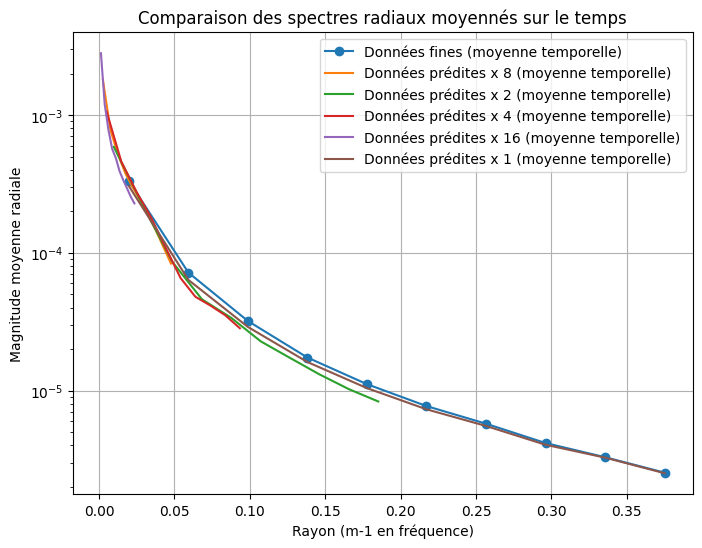

In [6]:
# Visualisation de la moyenne temporelle du spectre radial
#fenetre = 500
plt.figure(figsize=(8,6))

plt.plot(r_proj_gd[:10], rad_proj_mean_gd[:10],marker='o', label='Données fines (moyenne temporelle)')
plt.plot(r_proj_x8[:10], rad_proj_mean_x8[:10], label='Données prédites x 8 (moyenne temporelle)')
plt.plot(r_proj_x2[:10], rad_proj_mean_x2[:10], label='Données prédites x 2 (moyenne temporelle)')
plt.plot(r_proj_x4[:10], rad_proj_mean_x4[:10], label='Données prédites x 4 (moyenne temporelle)')
plt.plot(r_proj_x16[:10], rad_proj_mean_x16[:10], label='Données prédites x 16 (moyenne temporelle)')

plt.plot(r_proj_x1[:10], rad_proj_mean_x1[:10], label='Données prédites x 1 (moyenne temporelle)')

plt.xlabel('Rayon (m-1 en fréquence)')
plt.ylabel('Magnitude moyenne radiale')
plt.title('Comparaison des spectres radiaux moyennés sur le temps')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()